# ライブラリのインポートと基本設定

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ハイパーパラメータの設定
img_rows = 28
img_cols = 28
channels = 1
img_shape = (channels, img_rows, img_cols) # PyTorchは (C, H, W) 形式
z_dim = 100 # Latent Space（潜在空間）の次元数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator（生成器）の定義

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        # 1. 入力ベクトルを 7x7x256 のテンソルに変換するための全結合層
        # PyTorchでは (Batch, Channels, Height, Width) の順になるため (256, 7, 7) を目指します
        self.fc = nn.Linear(z_dim, 256 * 7 * 7)

        self.deconv_blocks = nn.Sequential(
            # 2. Transposed Convolution: 7x7x256 -> 14x14x128
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),

            # 3. Transposed Convolution: 14x14x128 -> 14x14x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),

            # 4. Transposed Convolution: 14x14x64 -> 28x28x1
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            # 出力層の Tanh Activation
            nn.Tanh()
        )

    def forward(self, z):
        # 全結合層を通してフラットなベクトルを出力
        x = self.fc(z)
        # テンソルを (Batch, Channels, Height, Width) にリシェイプ
        x = x.view(-1, 256, 7, 7)
        # 転置畳み込み層のブロックを通過
        img = self.deconv_blocks(x)
        return img

# Discriminator（識別器）の定義

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        
        # img_shape は通常 (Channels, Height, Width) = (1, 28, 28)
        channels = img_shape[0]

        self.conv_blocks = nn.Sequential(
            # 1. Convolution: 28x28x1 -> 14x14x32
            nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01, inplace=True),

            # 2. Convolution: 14x14x32 -> 7x7x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),

            # 3. Convolution: 7x7x64 -> 4x4x128 (※Kerasの計算に合わせるため端数は調整されます)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),

            # 4. Flatten & Output Layer
            nn.Flatten(),
            # 畳み込み後の特徴マップサイズに合わせて全結合層の入力次元を決定
            # 28 -> 14 -> 7 -> 4 とサイズが変化するため、4*4*128 となります
            nn.Linear(128 * 4 * 4, 1),
            # Sigmoid Activation
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.conv_blocks(img)
        return validity

# モデルの構築と最適化アルゴリズムの設定

In [5]:
# インスタンス化
generator = Generator(z_dim).to(device)
discriminator = Discriminator(img_shape).to(device)

# 損失関数: Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Optimizer（最適化アルゴリズム）: Adam
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 学習ループ

0 [D loss: 0.7583] [G loss: 0.8597]


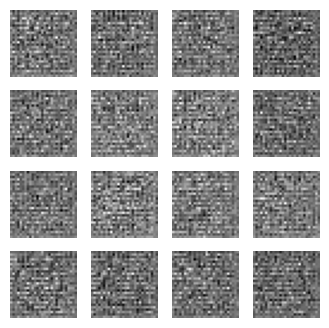

Saved model checkpoints at iteration 0
1000 [D loss: 0.2427] [G loss: 1.7952]


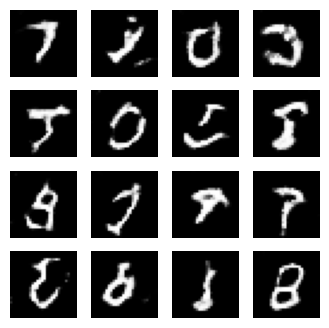

Saved model checkpoints at iteration 1000
2000 [D loss: 0.1940] [G loss: 2.6131]


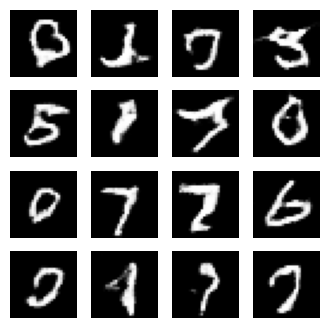

Saved model checkpoints at iteration 2000
3000 [D loss: 0.2198] [G loss: 1.7609]


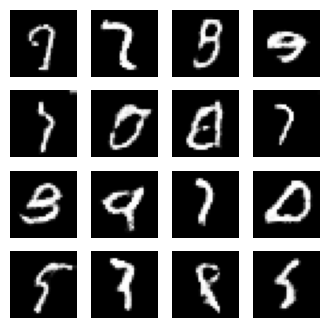

Saved model checkpoints at iteration 3000
4000 [D loss: 0.1705] [G loss: 2.3862]


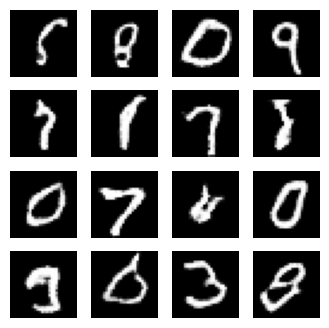

Saved model checkpoints at iteration 4000
5000 [D loss: 0.4643] [G loss: 3.8199]


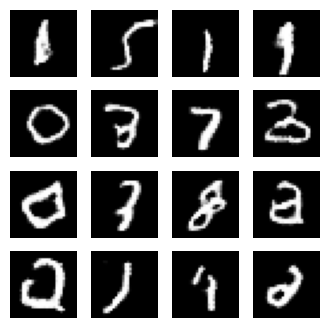

Saved model checkpoints at iteration 5000
6000 [D loss: 0.1835] [G loss: 3.4776]


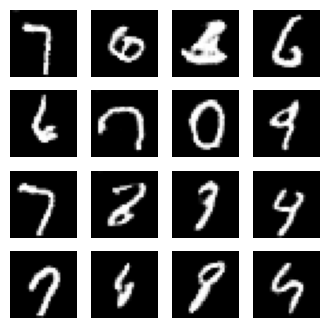

Saved model checkpoints at iteration 6000
7000 [D loss: 0.1470] [G loss: 3.3954]


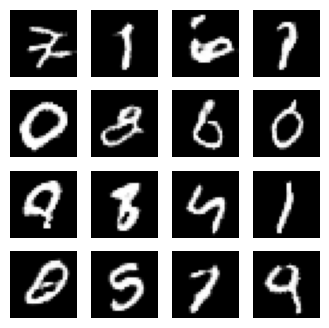

Saved model checkpoints at iteration 7000
8000 [D loss: 0.2540] [G loss: 1.5971]


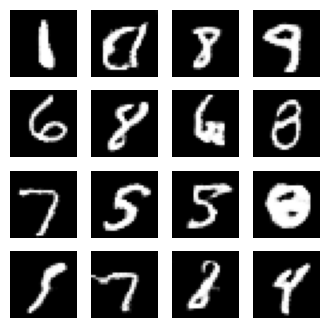

Saved model checkpoints at iteration 8000
9000 [D loss: 0.0924] [G loss: 3.5400]


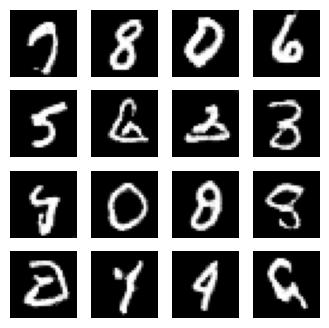

Saved model checkpoints at iteration 9000
10000 [D loss: 0.2506] [G loss: 3.4336]


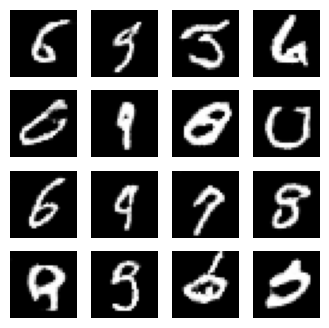

Saved model checkpoints at iteration 10000


In [6]:
def train(iterations, batch_size, sample_interval):
    # 保存用ディレクトリの作成（なければ作る）
    os.makedirs("checkpoints", exist_ok=True)

    # MNISTデータの読み込みと前処理 ([-1, 1]に正規化)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataloader = DataLoader(
        datasets.MNIST('.', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True, drop_last=True
    )

    losses = []
    iteration_checkpoints = []

    # イテレータの作成
    data_iter = iter(dataloader)

    for iteration in range(iterations+1):
        
        # --- データの準備 ---
        try:
            real_imgs, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            real_imgs, _ = next(data_iter)

        real_imgs = real_imgs.to(device)
        # 教師ラベル: 本物は1, 偽物は0
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # -------------------------
        #  Train Discriminator
        # -------------------------
        optimizer_D.zero_grad()

        # 本物の画像の判定
        d_loss_real = criterion(discriminator(real_imgs), valid)
        
        # 偽物の画像の生成と判定
        z = torch.randn(batch_size, z_dim).to(device)
        gen_imgs = generator(z)
        d_loss_fake = criterion(discriminator(gen_imgs.detach()), fake)

        # 誤差逆伝播と更新
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # 偽物を「本物(1)」と判定させることが目標
        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Progress Logging & Saving
        # ---------------------
        if (iteration) % sample_interval == 0:
            print(f"{iteration} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
            losses.append((d_loss.item(), g_loss.item()))
            iteration_checkpoints.append(iteration + 1)
            
            # 画像の保存・表示
            sample_images(generator)
            
            # === モデルの保存処理 (ここを追加) ===
            # GeneratorとDiscriminatorの重みをそれぞれ保存
            torch.save(generator.state_dict(), f"checkpoints/generator_{iteration}.pth")
            torch.save(discriminator.state_dict(), f"checkpoints/discriminator_{iteration}.pth")
            print(f"Saved model checkpoints at iteration {iteration}")
            
    return np.array(losses), iteration_checkpoints

# sample_images関数などはそのまま変更なしでOK

def sample_images(generator, rows=4, cols=4):
    generator.eval()
    z = torch.randn(rows * cols, z_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    gen_imgs = 0.5 * gen_imgs + 0.5 # [-1, 1] -> [0, 1]

    fig, axs = plt.subplots(rows, cols, figsize=(4, 4))
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[cnt, 0, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# 実行
losses, checkpoints = train(iterations=10000, batch_size=128, sample_interval=1000)

# 学習済み生成器の読み込みと画像生成

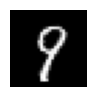

In [13]:
# --- 設定 ---
# 読み込みたいモデルのパス
checkpoint_path = "checkpoints/generator_10000.pth" 

# --- 1. モデルの枠組みを用意して、重みをロード ---
# まずモデルの構造（箱）を作る
generator = Generator(z_dim).to(device)

# 指定したパスから重み（中身）を読み込みむ
# map_location=device をつけることで、GPUで保存したモデルをCPUでも開けるようしている
generator.load_state_dict(torch.load(checkpoint_path, map_location=device))

# --- 2. Generatorで画像を生成 ---
generator.eval() # 推論モードへ（BatchNormなどを固定）

# ランダムなノイズを1つ作成 (バッチサイズ=1, 次元=100)
z = torch.randn(1, z_dim).to(device)

with torch.no_grad(): # 勾配計算をしない（メモリ節約）
    gen_img = generator(z)

# --- 3. 表示用に整形 ---
# (1, 1, 28, 28) -> (28, 28) に不要な次元を削除してNumpy化
image = gen_img.squeeze().cpu().numpy()

# 画素値を [-1, 1] から [0, 1] に戻す
image = 0.5 * image + 0.5

# --- 4. 表示 ---
plt.figure(figsize=(1, 1))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()